<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">
---

# **Módulo** | Big Data II - Armazenamento
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)<br>
Aluno [Marcos Pereira](https://www.linkedin.com/in/marcos-pereira-b84160300/)<br>

```


---

# **Tópicos**

<ol type="1">
  <li>Introdução;</li>
  <li>Orientação a coluna;</li>
  <li>Particionamento.</li>
</ol>

---

## 1\. Introdução.

### **1.1. Armazenamento distribuído**

A escala horizontal de recursos faz com que os dados sejam armazenados em arquivos (`csv`, `txt`, `parquet`, etc.), "quebrados" em blocos (128 MB geralmente) e **distribuídos** e **replicados** (três vezes geralmente) entre os nós do cluster. O gerenciador de *cluster* mantem um mapa da distribuição dos blocos. Esta característica de sistemas distribuídos é abstraída dos usuários comuns de um *cluster*.

## 2\. Orientação a coluna.

Tradicionalmente, os sistemas de armazenamento de dados (arquivos, bases de dados, etc.) trabalham com **orientação a linha**, ou seja, para acessar o valor de uma coluna, primeiro encontra-se sua linha. Como exemplo, imagine uma base de dados de vendas de jogos eletrônicos com a seguinte estrutura.

In [ ]:
%%writefile jogos.csv
"id","nome","plataforma","ano_lancamento","total_vendas_mm"
100,"Final Fantasy VII","PSX",1997,12.3
101,"Final Fantasy VIII","PSX",1999,9.6
102,"Final Fantasy IX","PSX",2000,5.5

A consulta SQL abaixo primeiro encontraria a linha com o `id` igual a 102 para então acessar o valor de 5.5 na coluna `total_vendas_mm`.

```sql
SELECT total_vendas_mm FROM jogos WHERE id = 102
```

Portanto, no formato **orientado a linha**, consultas com métricas de **agregação** faz com que o acesso ao dado da coluna a ser agregada também seja extraído linha a linha. Como exemplo, a consulta SQL abaixo seria equivalente ao código Python também abaixo:

```sql
SELECT SUM(total_vendas_mm) FROM jogos
```

In [ ]:
import csv
from functools import reduce

vals = []
lines = None

with open('jogos.csv', mode='r') as fp:
  lines = csv.reader(fp)
  next(lines, None)
  for line in lines:
    vals.append(float(line[4]))

sum_vals = reduce(lambda x, y: x + y, vals)

print(sum_vals)

Em geral, para o volume das bases de dados modernas, essa abordagem é inviável. Para lidar com essa situação, foram criados tipos de arquivos (`Apache Parquet`), bases de dados (`Apache HBase`) e estruturas de dados (`Apache Arrow`) **orientados a colunas**, onde os dados são "pivotados", ou seja, dados de uma mesma coluna são organizados como se estivessem em mesma linha. Portanto, a mesma consulta SQL (replicada abaixo) realizada em um sistema **orientado a colunas** executaria muito mais rápido.

```sql
SELECT SUM(total_vendas_mm) FROM jogos
```

> Sistemas **orientados a colunas** são ideias para **agregações** (base de cargas analíticas).

## 3\. Particionamento.

Para obsevar os benefícios que o **particionamento** trás para o armazenamento de grandes volumes de dados, vamos explorar as técnicas de particionamento na *cloud* da AWS, utilizando os serviços AWS S3 e AWS Athena, e o seu efeito combinado com a **orientação a coluna** através do `Apache Parquet`.

3.1. Faça o download do arquivo `crime.csv` (fonte [Kaggle](https://www.kaggle.com/yamqwe/chicago-crimee?select=chicago_crime_2014.csv)).

In [ ]:
!wget https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/crime.csv -q -O crime.csv

3.2. Leia os dados em um DataFrame Pandas e crie a coluna `reference_date`.

In [ ]:
import pandas as pd

filename = './crime'

df = pd.read_csv(f'./{filename}.csv')
df.head()

,index,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude
0,0,9446824,HX100141,01/01/2014 02:00:00 AM,0000X W ILLINOIS ST,0460,BATTERY,SIMPLE,STREET,False,False,1831,18,42.0,8.0,08B,41.890828,-87.630235
1,1,9446748,HX100020,01/01/2014 12:00:00 AM,006XX N DEARBORN ST,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,1832,18,42.0,8.0,06,41.893542,-87.629702
2,2,9446758,HX100030,01/01/2014 12:30:00 AM,052XX W RACE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,1523,15,28.0,25.0,14,41.890046,-87.756333
3,3,9446760,HX100027,01/01/2014 12:30:00 AM,053XX W WELLINGTON AVE,0460,BATTERY,SIMPLE,APARTMENT,True,False,2514,25,31.0,19.0,08B,41.935011,-87.759739
4,4,9446764,HX100054,01/01/2014 12:10:00 AM,014XX W LEXINGTON ST,0460,BATTERY,SIMPLE,STREET,False,False,1231,12,25.0,28.0,08B,41.872509,-87.663069


In [ ]:
df.shape

(274423, 18)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274423 entries, 0 to 274422
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 274423 non-null  int64  
 1   ID                    274423 non-null  int64  
 2   Case Number           274423 non-null  object 
 3   Date                  274423 non-null  object 
 4   Block                 274423 non-null  object 
 5   IUCR                  274423 non-null  object 
 6   Primary Type          274423 non-null  object 
 7   Description           274423 non-null  object 
 8   Location Description  274247 non-null  object 
 9   Arrest                274423 non-null  bool   
 10  Domestic              274423 non-null  bool   
 11  Beat                  274423 non-null  int64  
 12  District              274423 non-null  int64  
 13  Ward                  274421 non-null  float64
 14  Community Area        274422 non-null  float64
 15  

3.3. Persista o dado no DataFrame em um arquivo csv e em arquivos parquet, estes últimos comprimidos e particionados pela coluna `reference_date`.

In [ ]:
from datetime import datetime

df['reference_date'] = df['Date'].apply(lambda date: datetime.strptime(date.split(sep=' ')[0], '%m/%d/%Y').strftime('%Y-%m-%d'))

In [ ]:
df.shape

(274423, 19)

In [ ]:
df.head()

,index,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude,reference_date
0,0,9446824,HX100141,01/01/2014 02:00:00 AM,0000X W ILLINOIS ST,0460,BATTERY,SIMPLE,STREET,False,False,1831,18,42.0,8.0,08B,41.890828,-87.630235,2014-01-01
1,1,9446748,HX100020,01/01/2014 12:00:00 AM,006XX N DEARBORN ST,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,1832,18,42.0,8.0,06,41.893542,-87.629702,2014-01-01
2,2,9446758,HX100030,01/01/2014 12:30:00 AM,052XX W RACE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,1523,15,28.0,25.0,14,41.890046,-87.756333,2014-01-01
3,3,9446760,HX100027,01/01/2014 12:30:00 AM,053XX W WELLINGTON AVE,0460,BATTERY,SIMPLE,APARTMENT,True,False,2514,25,31.0,19.0,08B,41.935011,-87.759739,2014-01-01
4,4,9446764,HX100054,01/01/2014 12:10:00 AM,014XX W LEXINGTON ST,0460,BATTERY,SIMPLE,STREET,False,False,1231,12,25.0,28.0,08B,41.872509,-87.663069,2014-01-01


Observa-se que a coluna `reference_date` de fato divide os dados em grupos equilibrados. Sendo assim, vamos salvar o `DataFrame` Pandas em arquivos comprimidos no formato `Parquet`, particionados pela coluna `reference_date`.

In [ ]:
df.to_parquet('./crime', engine='pyarrow', compression='gzip', partition_cols='reference_date')

Vamos também salver o `DataFrame` Pandas no formato `CSV` para garantir que os arquivos de ambas as abordagens possuem a coluna `reference_date`.

In [ ]:
df.to_csv('./crime_enriched.csv', sep=',', index=False)

3.4. Crie os recursos no AWS S3 e AWS IAM e persista os dados em seus respectivos *buckets*.

Na AWS, vamos criar os recursos tanto para o arquivo no formato `csv` quanto para os arquivos no formato `parquet`.

 - **CSV**


Vamos criar `Bucket` no `AWS S3` para armazenar o arquivo.

 - **Parquet**

Vamos criar `Bucket` no `AWS S3` para armazenar os arquivos e suas partições e usuário no `AWS IAM` para fazer o *upload* dos arquivos e suas partições.

Então, vamos inserir as credenciais no Python.

In [ ]:
from getpass import getpass

aws_access_key_id = getpass()

··········


In [ ]:
from getpass import getpass

aws_secret_access_key = getpass()

··········


E instalar o pacote Boto3, o SDK Python da AWS.

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.7 MB/s eta 0:00:00


Por fim, vamos criar o nosso cliente e fazer o upload das partições.

In [ ]:
import boto3

client = boto3.client(
  's3',
  aws_access_key_id=aws_access_key_id,
  aws_secret_access_key=aws_secret_access_key
)

In [ ]:
import os

BUCKET = 'modulo-41-masp-parquet'

i = 0

for root, dirs, files in os.walk('./crime'):
  elapsed = f'{round(100*i/365, 2)} %'
  print(elapsed)
  for file in files:
    path = os.path.join(root, file)
    bucket_path = '/'.join(path.split(sep='/')[2:])
    client.upload_file(path, BUCKET, bucket_path)
  i = i + 1


0.0 %
0.27 %
0.55 %
0.82 %
1.1 %
1.37 %
1.64 %
1.92 %
2.19 %
2.47 %
2.74 %
3.01 %
3.29 %
3.56 %
3.84 %
4.11 %
4.38 %
4.66 %
4.93 %
5.21 %
5.48 %
5.75 %
6.03 %
6.3 %
6.58 %
6.85 %
7.12 %
7.4 %
7.67 %
7.95 %
8.22 %
8.49 %
8.77 %
9.04 %
9.32 %
9.59 %
9.86 %
10.14 %
10.41 %
10.68 %
10.96 %
11.23 %
11.51 %
11.78 %
12.05 %
12.33 %
12.6 %
12.88 %
13.15 %
13.42 %
13.7 %
13.97 %
14.25 %
14.52 %
14.79 %
15.07 %
15.34 %
15.62 %
15.89 %
16.16 %
16.44 %
16.71 %
16.99 %
17.26 %
17.53 %
17.81 %
18.08 %
18.36 %
18.63 %
18.9 %
19.18 %
19.45 %
19.73 %
20.0 %
20.27 %
20.55 %
20.82 %
21.1 %
21.37 %
21.64 %
21.92 %
22.19 %
22.47 %
22.74 %
23.01 %
23.29 %
23.56 %
23.84 %
24.11 %
24.38 %
24.66 %
24.93 %
25.21 %
25.48 %
25.75 %
26.03 %
26.3 %
26.58 %
26.85 %
27.12 %
27.4 %
27.67 %
27.95 %
28.22 %
28.49 %
28.77 %
29.04 %
29.32 %
29.59 %
29.86 %
30.14 %
30.41 %
30.68 %
30.96 %
31.23 %
31.51 %
31.78 %
32.05 %
32.33 %
32.6 %
32.88 %
33.15 %
33.42 %
33.7 %
33.97 %
34.25 %
34.52 %
34.79 %
35.07 %
35.34 %
35.62 %
35

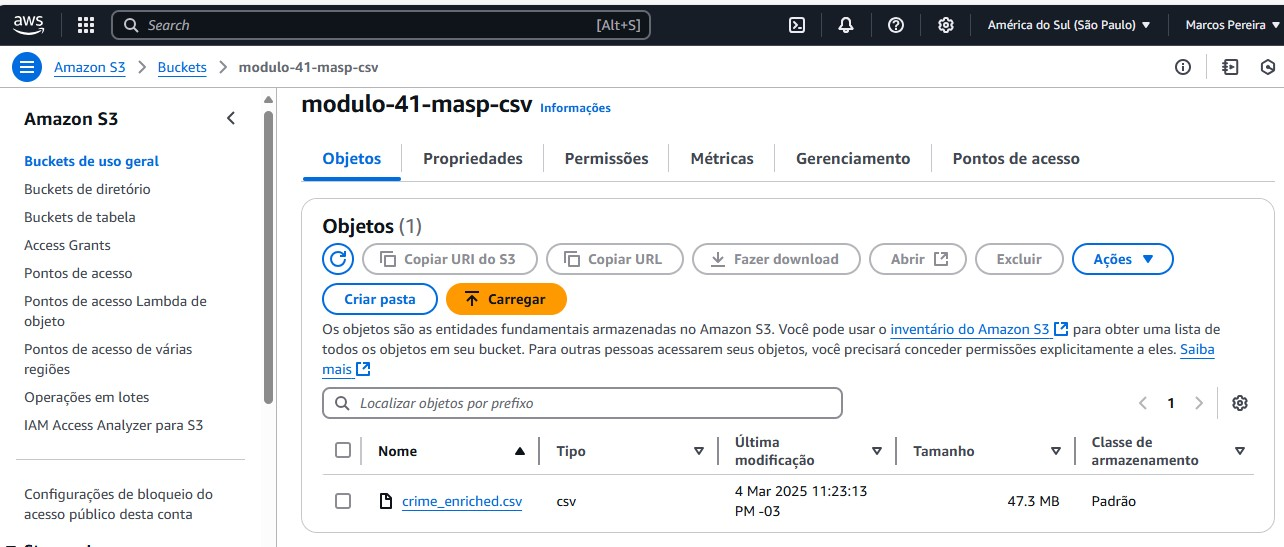

>Bucket **modulo-41-masp-csv** criado com 1 arquivo.

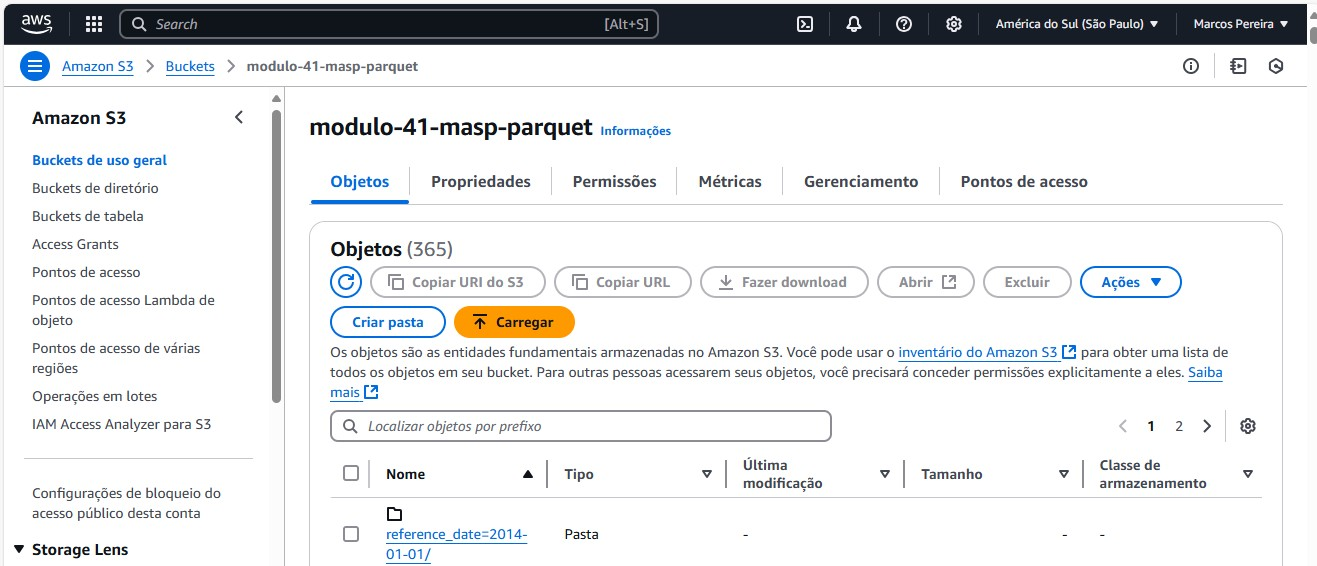

>Bucket **modulo-41-masp-parquet** criado com 365 arquivos.

3.5. Crie os recursos no AWS Athena e execute as consultas SQL da aula.

Na AWS, vamos criar os recursos tanto para o arquivo no formato csv quanto para os arquivos no formato parquet.

 - **CSV**

Criar tabela no `AWS Athena` apontando para o arquivo.

```sql
CREATE EXTERNAL TABLE `crime_csv`(
  `index` bigint,
  `id` string,
  `case number` string,
  `date` string,
  `block` string,
  `iucr` string,
  `primary type` string,
  `description` string,
  `location description` string,
  `arrest` string,
  `domestic` string,
  `beat` string,
  `district` string,
  `ward` string,
  `community area` string,
  `fbi code` string,
  `latitude` string,
  `longitude` string,
  `reference_date` string)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.serde2.OpenCSVSerde'
 WITH SERDEPROPERTIES (
   'separatorChar' = ',',
   'quoteChar' = '\"',
   'escapeChar' = '\\'
   )
STORED AS INPUTFORMAT
  'org.apache.hadoop.mapred.TextInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://modulo-41-masp-csv/'
TBLPROPERTIES (
  "skip.header.line.count"="1")
```

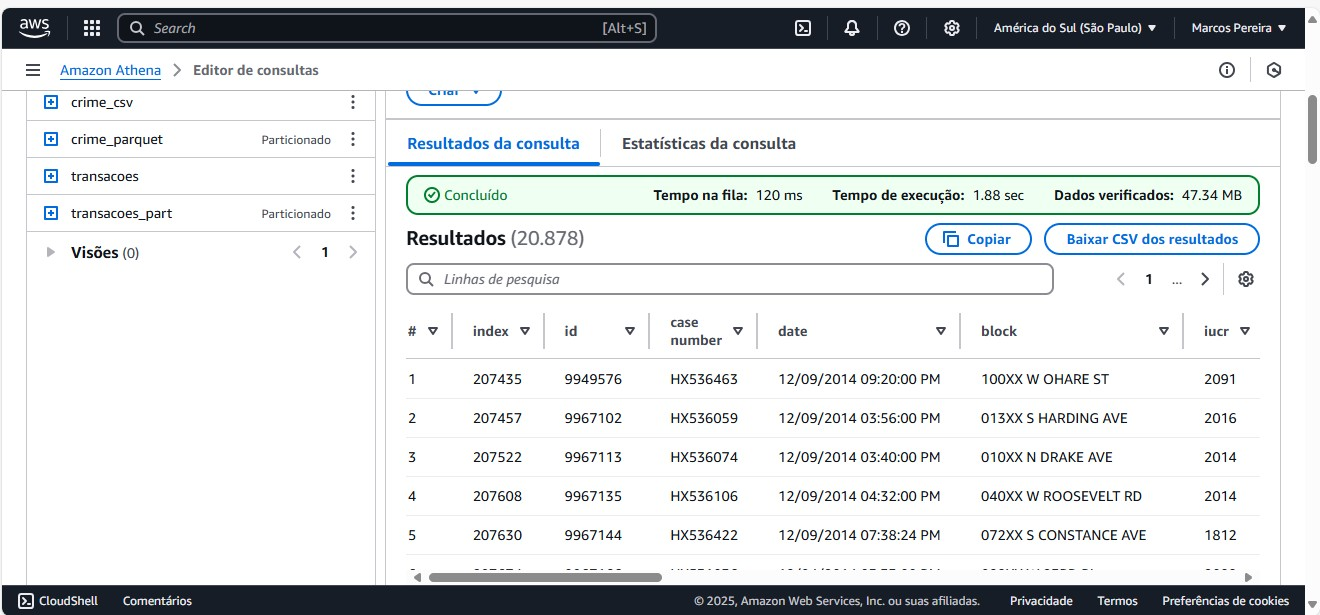

>Tabela **crime-csv** criada com **47.33MB**.

 - **Parquet**

Criar tabela no `AWS Athena` apontando para os arquivos e suas partições e carregar as partições.

```sql
CREATE EXTERNAL TABLE `crime_parquet`(
  `index` bigint,
  `id` bigint,
  `case number` string,
  `date` string,
  `block` string,
  `iucr` string,
  `primary type` string,
  `description` string,
  `location description` string,
  `arrest` boolean,
  `domestic` boolean,
  `beat` bigint,
  `district` bigint,
  `ward` double,
  `community area` double,
  `fbi code` string,
  `latitude` double,
  `longitude` double)
PARTITIONED BY (
  `reference_date` string)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://modulo-41-masp-parquet/'
```

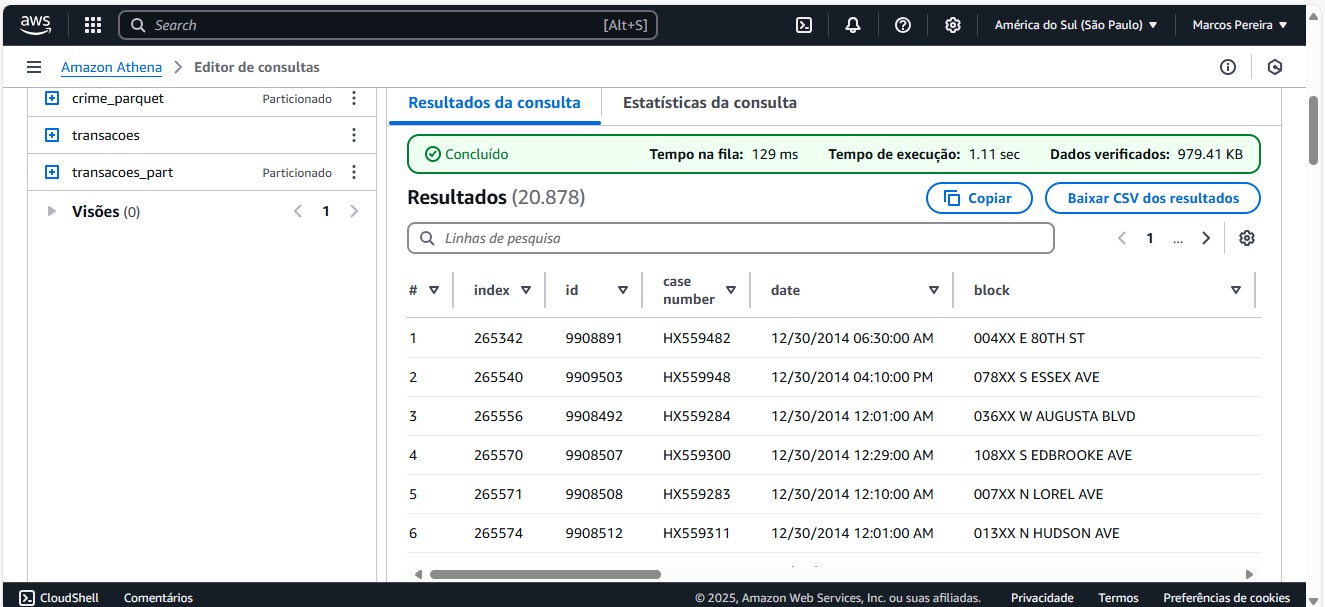

>Tabela **crime-parquet** criada com **0.98MB**.

Por fim, vamos executar um conjunto de consultas SQL em ambas as tabelas e observar a quantidade de dados escaneados.

 - Efeito da **orientação a coluna**:

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_csv
GROUP BY 1
ORDER BY 2 DESC;
```

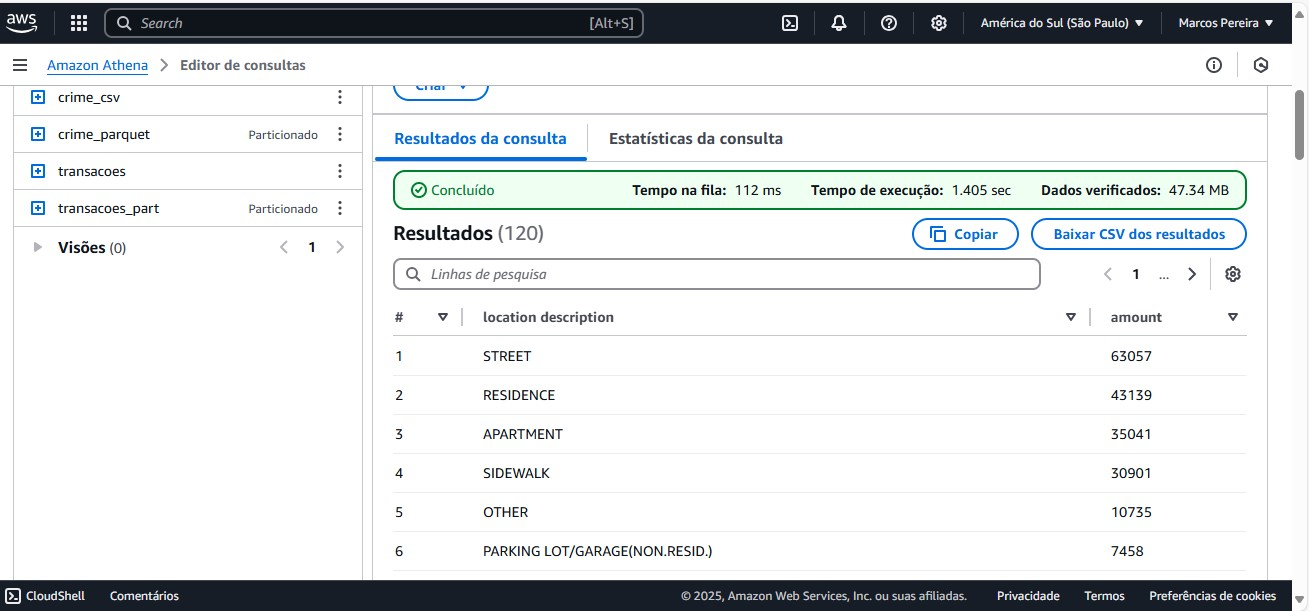

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_parquet
GROUP BY 1
ORDER BY 2 DESC;
```

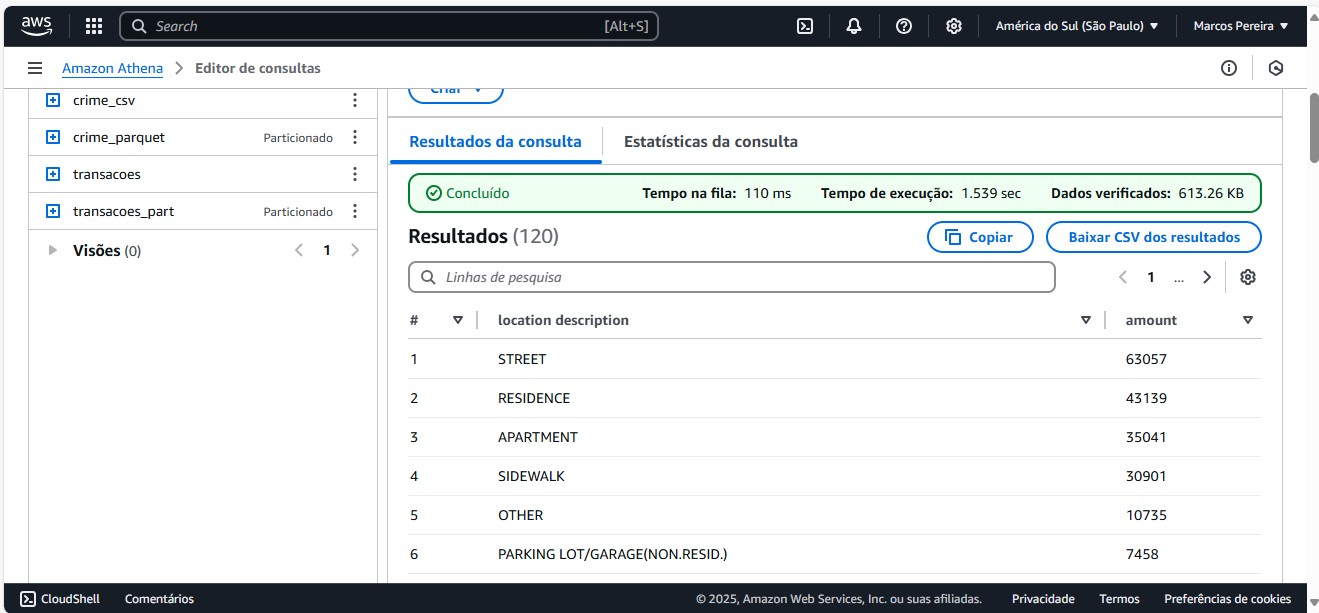

A consulta escaneou 47.34 MB para a tabela crime_csv, que é o mesmo tamanho do arquivo, logo um full scan. Já para a tabeka crime_parquet, a consulta escaneou **0.61 MB**. Ou seja, a tabela com o dado **orientado** a coluna escaneou **78 vezes** menos dados para a consulta SQL que seu par em csv.

 - Efeito do **particionamento**:

```sql
SELECT *
FROM crime_csv
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
```

```sql
SELECT *
FROM crime_parquet
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
```

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabela `crime_parquet`, a consulta escaneou 0.98 MB. Ou seja, a tabela com o dado **particionado** escaneou **48.30 vezes** menos dados para a consulta SQL que seu par em `csv`.

 - Efeito da **orientação a coluna** e do **particionamento**:

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_csv
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
GROUP BY 1
ORDER BY 2 DESC
```

```sql
SELECT "location description", COUNT(1) as "amount"
FROM crime_parquet
WHERE CAST(reference_date as DATE) BETWEEN DATE '2014-12-01' and DATE '2014-12-31'
GROUP BY 1
ORDER BY 2 DESC
```

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabela `crime_parquet`, a consulta escaneou 0.04 MB. Ou seja, a tabela com o dado **particionado** e **orientado a coluna** escaneou **1183.5 vezes** menos dados para a consulta SQL que seu par em `csv`.

---